<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Discovering-DNA-motifs-using-convolutional-neural-networks" data-toc-modified-id="Discovering-DNA-motifs-using-convolutional-neural-networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Discovering DNA motifs using convolutional neural networks</a></span></li><li><span><a href="#EWSR1-motif" data-toc-modified-id="EWSR1-motif-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EWSR1 motif</a></span></li><li><span><a href="#Generating-training-examples" data-toc-modified-id="Generating-training-examples-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating training examples</a></span></li><li><span><a href="#Preprocessing-the-data:-one-hot-encoding" data-toc-modified-id="Preprocessing-the-data:-one-hot-encoding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing the data: one-hot encoding</a></span></li><li><span><a href="#Building-a-convolution-neural-network" data-toc-modified-id="Building-a-convolution-neural-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Building a convolution neural network</a></span></li><li><span><a href="#Training-and-evaluting-the-network" data-toc-modified-id="Training-and-evaluting-the-network-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training and evaluting the network</a></span></li><li><span><a href="#Interrogating-the-learned-convolution-filter" data-toc-modified-id="Interrogating-the-learned-convolution-filter-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Interrogating the learned convolution filter</a></span></li><li><span><a href="#Two-ways-to-achieve-high-performance" data-toc-modified-id="Two-ways-to-achieve-high-performance-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Two ways to achieve high performance</a></span></li><li><span><a href="#A-second-pass-at-interrogating-the-convolution-filter" data-toc-modified-id="A-second-pass-at-interrogating-the-convolution-filter-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>A second pass at interrogating the convolution filter</a></span></li><li><span><a href="#Learning-part-of-a-motif-can-be--sufficient-for-high-performance" data-toc-modified-id="Learning-part-of-a-motif-can-be--sufficient-for-high-performance-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Learning part of a motif can be  sufficient for high performance</a></span></li><li><span><a href="#Other-things-to-explore" data-toc-modified-id="Other-things-to-explore-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Other things to explore</a></span></li></ul></div>

Based upon [Gökçen Eraslan's PyCon talk](https://github.com/gokceneraslan/dnaconvnet-notebook).

## Discovering DNA motifs using convolutional neural networks

The goal is to train a convolutional neural network to predict whether a given input sequence contains a given DNA-binding motif. We will do this by generating synthetic training examples (sequences) that have been labeled according to whether they contain a given motif or not. The hope is that the trained network can be used to recover, somehow, the injected motif. 

## EWSR1 motif 

We fetch the following motif from [JASPAR](http://jaspar.genereg.net/cgi-bin/jaspar_db.pl?ID=MA0149.1&rm=present&collection=CORE):
![title](http://jaspar.genereg.net/static/logos/MA0149.1.BIG.png)


This motif is a visualization of the "frequency matrix":

In [1]:
import numpy as np
motif = np.array([[   0,   2, 104, 104,   1,   2, 103, 102,   0,   0,  99, 105,   0,   0, 100, 102,   5,   3],
                  [   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4,   0,   0,   2,   3,   0,   0,   3],
                  [ 105, 103,   1,   1, 104, 102,   2,   3, 104, 103,   2,   0, 105, 103,   0,   2,  97,  97],
                  [   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   2,   1,   3,   2]])

Each row in this matrix corresponds to one of the four possible nucleotides and the columns correspond to  positions within the binding site of the transcription factor. The matrix elements indicate the frequency with which the corresponding nucleotide was observed at the corresponding position in the binding site. 


## Generating training examples 

We wish to create a set of "positive" training examples in which the motif is embedded. We can do this by drawing nucleotides at random with probabilities proporitional to the frequency matrix, and then extending the sequence so generated upstream and downstream by drawing nucleotides at random with equal probability: 

In [2]:
sequence_length = 30
motif_plus_background = np.hstack([np.ones((4, (sequence_length-motif.shape[1])//2)), 
                                   motif,
                                   np.ones((4, (sequence_length-motif.shape[1])//2))])

number_training_examples = 10000
training_examples_positive = \
np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                           size=number_training_examples//2, 
                           p=motif_plus_background[:,position]/float(np.sum(motif_plus_background[:,position]))) 
          for position in range(sequence_length)]).transpose()

sequences_positive = []
for training_example_positive in training_examples_positive: 
    sequences_positive.append(''.join(training_example_positive))
    
labels_positive = np.ones(shape=len(sequences_positive), dtype=int)

Now let's produce the negative training examples by sampling nucleotides with equal frequency, regardless of their position in the sequence: 

In [3]:
training_examples_negative = \
np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                           size=number_training_examples//2, 
                           p=np.array([1,1,1,1])/4.0) 
          for position in range(sequence_length)]).transpose()

sequences_negative = []
for training_example_negative in training_examples_negative: 
    sequences_negative.append(''.join(training_example_negative))

labels_negative = np.zeros(shape=len(sequences_negative), dtype=int)

Wrap the examples up in a dataframe to visualize the positive examples...

In [4]:
import pandas as pd
from collections import OrderedDict
df_training = pd.DataFrame(OrderedDict([('sequence', np.concatenate((sequences_positive, sequences_negative))),
                                        ('observed_label', np.concatenate((labels_positive, labels_negative)))]))
df_training[:5]

,sequence,observed_label
0,ACGTGAGGAAGGAAGGAAGGAATGAGTCTC,1
1,GGGTCAGGAAGGGAGGAAGGAATGTTGACA,1
2,AGGGCTGGAAGGAAGGAAGGAAGGATGCAC,1
3,GGACTAGGAAGGAAGGCAGCAAGGAGATAT,1
4,TGTGGGGGAAGGAAGGAAGGAAGGTTGCCA,1


... and the negative examples: 

In [5]:
half_way = len(df_training)//2
df_training[half_way:half_way+5]

,sequence,observed_label
5000,GTGCTTACTAACAACACCATGTAGTTTGGC,0
5001,GGAGGTAATAGAAGATACAATGAAGAAAGA,0
5002,ATAATGCTTCGAACTGGCGTTAGTGACTAT,0
5003,TTGTCTAGGTTGGTCTTGCTCCGATTGTAC,0
5004,TACATCATCAAAACTCATTATTAATCTTTT,0


## Preprocessing the data: one-hot encoding

Since the sequences are categorical data, we must encode them as numbers before passing them into a function that maps them to class labels. We use "one-hot encoding", creating a tensor with dimensions `(number_examples, sequence_length, number_channels)` where `number_channels = 4`: 

In [6]:
from load_preprocess_data import _one_hot_encode_conv1d

encoded_sequences = []
observed_labels = []
for sequence, observed_label in zip(df_training['sequence'], df_training['observed_label']):
    encoded_sequences.append(_one_hot_encode_conv1d(sequence))
    observed_labels.append([observed_label])
encoded_sequences = np.array(encoded_sequences)
observed_labels = np.array(observed_labels)
print('encoded_sequences.shape: ', encoded_sequences.shape)
print('observed_labels.shape:', observed_labels.shape)

encoded_sequences.shape:  (10000, 30, 4)
observed_labels.shape: (10000, 1)


Since the positive examples appear at the head of the list of examples, and the negative examples at the tail, there is a danger that the network will be influenced by  this artifact. This is combatted by shuffling the data before splitting it into training and validation sets. [Keras will not shuffle before splitting](https://keras.io/getting-started/faq/#how-is-the-validation-split-computed), so we must shuffle the data ourselves. (Keras will however shuffle the training data at each epoch: [see here](https://keras.io/getting-started/faq/#is-the-data-shuffled-during-training).) 

In [7]:
permutation = np.random.permutation(len(observed_labels))

encoded_sequences = encoded_sequences[permutation, :, :]
observed_labels = observed_labels[permutation, :]

Finally we hold out some data for testing later: 

In [8]:
test_set_size = min(1000, int(0.1*len(encoded_sequences)))

encoded_sequences_test = encoded_sequences[:test_set_size, :, :]
encoded_sequences = encoded_sequences[test_set_size:, :, :]

observed_labels_test = observed_labels[:test_set_size, :]
observed_labels = observed_labels[test_set_size:, :]

## Building a convolution neural network 

Next, we set up a convolution neural network to map sequence to labels: 

In [9]:
# https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
import keras.backend as K
K.clear_session()

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv1D(filters=1, 
                 kernel_size=motif.shape[1], 
                 input_shape=(sequence_length, 4), 
                 use_bias=False,
                 padding='valid',
                 activation='relu'))

print('conv filter has dimension kernel_size X number_input_channels X number_output_channels')
print('shape of conv filter', model.layers[0].get_weights()[0].shape)
print('')

# INVERTED DROPOUT
# "Dropout" gets applied to the output of preceding layer (at training time only):
# https://keras.io/layers/core/#dropout
# weights are scaled by inverse of dropout rate (at training time only):
# see: line 2277 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
# also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
# also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
model.add(Dropout(rate=0.5)) # including dropout moves the converged values of loss and accuracy into a "reasonable" range

model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']) 
# "acc" is an alias for "binary_accuracy" when "loss" is "binary_crossentropy":
# https://github.com/keras-team/keras/blob/351e7a992d8f948e373e321252a35824da77ac35/keras/engine/training.py#L383
# https://github.com/keras-team/keras/blob/cd44c6e0aaff4bb52a060d778025b32dbde09b44/keras/metrics.py#L26 

print('model.inputs', model.inputs)
print('model.outputs', model.outputs)
model.summary()

# save model summary to disk
from contextlib import redirect_stdout
with open('model.summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Using TensorFlow backend.


conv filter has dimension kernel_size X number_input_channels X number_output_channels
shape of conv filter (18, 4, 1)

model.inputs [<tf.Tensor 'conv1d_1_input:0' shape=(?, 30, 4) dtype=float32>]
model.outputs [<tf.Tensor 'dense_1/Sigmoid:0' shape=(?, 1) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 13, 1)             72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 1)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


## Training and evaluting the network

Next, let's train the network we have built: 

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath="model.best.hdf5", 
                             save_weights_only=False,
                             monitor='val_acc', 
                             verbose=0,
                             save_best_only=True,
                             period=2)

from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='./logs', 
                          histogram_freq=1, 
                          write_graph=False, 
                          write_grads=True, 
                          write_images=True) # visualize model weights as images

history = model.fit(x=encoded_sequences, 
                    y=observed_labels, 
                    validation_split=0.2, 
                    epochs=int(200*(10000/number_training_examples)),
                    verbose=0,
                    callbacks=[checkpoint, tensorboard]) 

... and monitor it's performance during the training process: 

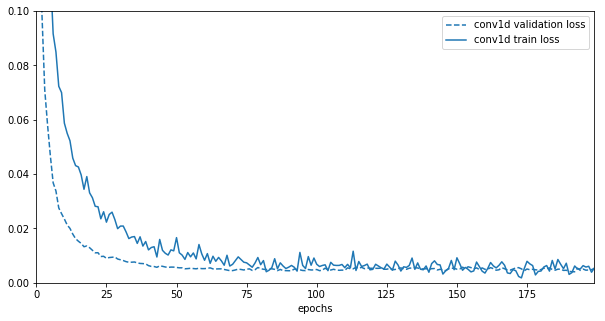

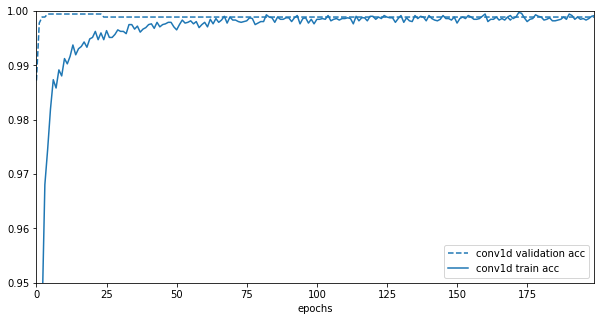

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_history(histories, key='loss', ymin=None, ymax=None):
    plt.figure(figsize=(10,5))    
    for name, history in histories:
        validation_plot = plt.plot(history.epoch, 
                                   history.history['val_' + key], 
                                   '--', 
                                   label=name + ' validation ' + key)
        plt.plot(history.epoch, 
                 history.history[key], 
                 color=validation_plot[0].get_color(),
                 label=name + ' train ' + key)
        plt.xlabel('epochs')
        plt.legend()
        plt.xlim([0, max(history.epoch)])
        if ymin is not None:
            plt.ylim(bottom=ymin)
        if ymax is not None:
            plt.ylim(top=ymax)
    
plot_history([('conv1d', history)], key='loss', ymin=0, ymax=0.1)
plot_history([('conv1d', history)], key='acc', ymin=0.95, ymax=1)

After convergence, the model performs very well! It's accuracy is far greater than 50%, which is the baseline accuracy associated with randomly predicting labels when the classes are "balanced" (the number of positive and negative examples are equal). 

Note: Training and validation losses (as computed above) may differ for the reasons below. These confounding factors may be controlled for by making predictions in exactly the same way for training, validation and test sets, e.g. using `model.predict` in Keras.

* regularization (see [here](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss) and ["because [this] penalty is only added at training time, the loss for this network will be much higher at training than at test time"](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#add_weight_regularization)
)
* the time during training at which the loss is evaluated (see [here](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss)) 

 

The high performance indicated by the classification accuracy is confirmed by examining the confusion matrix (for a given threshold on the probability output of the network) and the ROC (which exhaustively varies that threshold): 

Confusion matrix (threshold = 0.5):
 [[4493    3]
 [   0 4504]]


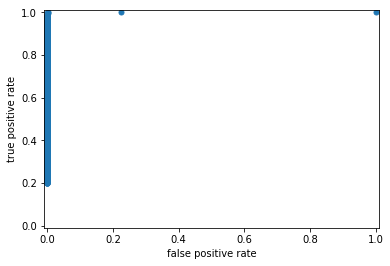

In [12]:
predicted_probabilities = model.predict(encoded_sequences)

from sklearn.metrics import confusion_matrix
threshold = 0.5
cm = confusion_matrix(y_true=observed_labels, 
                      y_pred=predicted_probabilities>threshold)
print('Confusion matrix (threshold = {}):\n'.format(threshold), cm)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(observed_labels, predicted_probabilities)
plt.plot(fpr, tpr, '.', ms=10)
_ = plt.xlabel('false positive rate')
_ = plt.ylabel('true positive rate')
_ = plt.xlim([-0.01, 1.01])
_ = plt.ylim([-0.01, 1.01])

## Interrogating the learned convolution filter

Does the network perform so well because the convolution filter it learns matches the motif that was injected into the positive examples? The simplest way to approach this question is to compare the matrices representing the original motif and the learned convolution filter: 

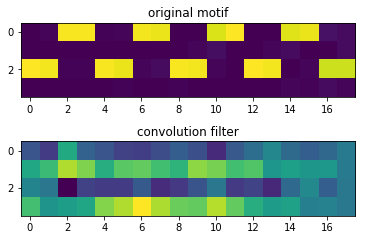

In [13]:
plt.subplot(2, 1, 1)
plt.imshow(motif)
_ = plt.xticks(np.arange(0, 18, step=2))
_ = plt.title('original motif')

convolution_filter = model.layers[0].get_weights()[0].squeeze().transpose()

plt.subplot(2, 1, 2)
plt.imshow(convolution_filter)
_ = plt.xticks(np.arange(0, 18, step=2))
_ = plt.title('convolution filter')

Are these matrices similar in any respect? Perhaps, but clearly this approach to interrogating the filter needs to be refined if we are to come away with some intuition about the origin of the high performance of the neural network.

In particular, should we expect that, at each position (the x-axes in the images above), the value of the convolution filter is largest at the nucleotide (y-axis) at which the PWM of the motif is maximal in value? Or should we expect the opposite, namely that the filter is smallest where the motif is largest? The answer to this question depends upon how the network uses the convolution filter to make predictions, which we consider next. 

## Two ways to achieve high performance 

Our network implements a sequence of functional transformations that convert the input sequence $s$ into a probability, $p$, that the sequence belongs to the positive class. This probability is computed as:

\begin{equation} 
p = \sigma \left( \, \Sigma_i a_i w_i + b \, \right) 
\end{equation} 

where $\sigma$ is the sigmoid activation function, $w_i$ and $b$ are trainable parameters and $a_i$ is the activation of the $i$th hidden neuron. That activation is in turn computed as 

\begin{equation} 
a_i = r(\, (s*f)_i \, ) 
\end{equation} 

where $r$ is the ReLU activation function, $s$ is the input sequence (one-hot-encoded), $f$ is the convolution filter, and `*` represents the convolution operation. 

With this notation in hand, we may depict schematically one possible way in which the network could correctly predict class labels (below, the positive class is labeled "1" and the negative class is labeled "0"): 

<table>
    <caption>Schema #1</caption>
    <tr>
        <th>class</th> <th>s*f</th> <th>a</th> <th>w</th> <th>b</th> <th>p</th>     
    </tr> 
    <tr> 
        <td>1</td> <td>-</td> <td>0</td> <td rowspan="2">-</td> <td rowspan="2">+</td> <td>1</td>
    </tr> 
    <tr> 
        <td>0</td> <td>+</td> <td>+</td> <td>0</td>
    </tr> 
</table> 

For example, if the input sequence is in the positive class, then this table conveys that convolving with the filter yields large negative numbers, which when passed through ReLU give zeroes, which when multiplied by negative weights $w$ and added to a positive bias $b$ yields a positive number, which gets mapped to a number $p$ close to one after passing through the sigmoid function. 

The alternate way to correctly predict classes is to reverse the sign of the convolution $s*f$ on positive and negative examples (and simultaneously reverse the signs of the weights and biases, $w$ and $b$):


<table>
    <caption>Schema #2</caption>
    <tr>
        <th>class</th> <th>s*f</th> <th>a</th> <th>w</th> <th>b</th> <th>p</th>     
    </tr> 
    <tr> 
        <td>1</td> <td>+</td> <td>+</td> <td rowspan="2">+</td> <td rowspan="2">-</td> <td>1</td>
    </tr> 
    <tr> 
        <td>0</td> <td>-</td> <td>0</td> <td>0</td>
    </tr> 
</table>

My experiments show that the training process always converges on a high-performance predictor that can be described using one of the two schema above (though the convolution filter that evolves varies). 



For example, here are the activations $a_i$ of the convolution layer and the weights $w_i$ that multiply them for a particular example and for the network we trained in this notebook:

Schema #1 (see table above)


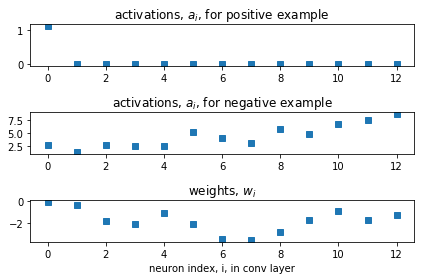

In [14]:
from keras.models import Model
conv_layer_model = Model(inputs=model.input,
                         outputs=model.layers[0].output)

positive_example_index = next(index for index, label in enumerate(observed_labels_test.squeeze()) if label == 1)
negative_example_index = next(index for index, label in enumerate(observed_labels_test.squeeze()) if label == 0)

activations_positive_example = conv_layer_model.predict(np.array([encoded_sequences_test[positive_example_index]])).squeeze()
activations_negative_example = conv_layer_model.predict(np.array([encoded_sequences_test[negative_example_index]])).squeeze()

weights = model.layers[3].get_weights()[0].squeeze()

plt.subplot(3, 1, 1)
plt.plot(activations_positive_example, 's')
plt.title('activations, $a_i$, for positive example')

plt.subplot(3, 1, 2)
plt.plot(activations_negative_example, 's')
plt.title('activations, $a_i$, for negative example')

plt.subplot(3, 1, 3)
_ = plt.plot(weights, 's')
_ = plt.xlabel('neuron index, i, in conv layer')
_ = plt.title('weights, $w_i$')

plt.tight_layout()

bias = float(model.layers[3].get_weights()[1])
print('Schema #{} (see table above)'.format(1 if bias > 0 else 2))

## A second pass at interrogating the convolution filter 

Now that we have classified the networks that evolve during training, we can return to the question of how to interrogate the convolution filter. 

In Schema #1, what drives the network to correctly predict the label of positive examples are negative values of the convolution filter (look at the second column of the table and remember that $s$ is one-hot-encoded and therefore always positive). This suggests that, when the network belongs to Schema #1, we should extract a "consensus sequence" from the convolution filter by picking out the nucleotides at each position that are **most negative.** 

In contrast, in Schema #2, correct predictions on positive examples result from positive values of the convolution filter (again see the second column of the corresponding table), implying that, when the network belongs to Schema #2,  the consensus sequence should be obtained by finding the nucleotides at each position at which the filter is **most positive.**

In [15]:
def consensus_sequence(matrix, model=None): 
    nucleotides = ['A','C','G','T']
    if model: 
        # use bias to determine which schema the network belongs to:
        bias = float(model.layers[3].get_weights()[1]) 
        arg = np.argmin if bias > 0.0 else np.argmax
    else: 
        arg = np.argmax
    return ''.join([nucleotides[arg(matrix[:, position])] 
                    for position in range(matrix.shape[1])])

consensus_sequence_motif = consensus_sequence(motif)
consensus_sequence_filter = consensus_sequence(convolution_filter, model=model)

print('motif consensus sequence:', consensus_sequence_motif)
print('convolution filter consensus sequence:', consensus_sequence_filter)

motif consensus sequence: GGAAGGAAGGAAGGAAGG
convolution filter consensus sequence: AAGGGGAGGAAGGGGAGT


Now we are getting somewhere! Clearly the consensus sequence of the filter is similar to that of the original motif. In particular, the filter sequence is closer to the motif sequence than any random sequence is: 

alignment score of filter sequence to motif sequence: 11.0

alignments of filter sequence to motif sequence:

-AAGGGGAGGAAGGGGAGT
-X|X||X|||||||XXX|-
GGAAGGAAGGAAGGAAGG-



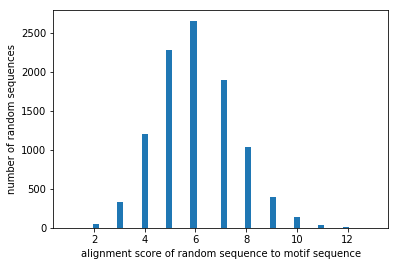

In [16]:
from Bio import Align
internal_gap_score = -100 

def generate_random_alignment_scores(): 
    random_alignment_scores = []
    for i in range(10000):
        random_sequence = ''.join(np.random.choice(['A', 'C', 'G', 'T'], 
                                                  size=motif.shape[1], 
                                                  p=np.array([1,1,1,1])/4.0))
        aligner = Align.PairwiseAligner()
        aligner.internal_gap_score = internal_gap_score
        random_alignment_scores.append(
            aligner.align(random_sequence, consensus_sequence_motif).score)
    return random_alignment_scores

plt.hist(generate_random_alignment_scores(), bins=50)
plt.xlabel('alignment score of random sequence to motif sequence')
plt.ylabel('number of random sequences')

aligner = Align.PairwiseAligner()
aligner.internal_gap_score = internal_gap_score
alignments = aligner.align(consensus_sequence_filter, consensus_sequence_motif)
print('alignment score of filter sequence to motif sequence:', alignments.score)
print()
print('alignments of filter sequence to motif sequence:')
print()
for alignment in alignments: 
    print(alignment)

## Learning part of a motif can be  sufficient for high performance



It is commonly thought that the filters in the first convolution layer of a neural network always learn Position Weight Matrices of sequence motifs. What we have found is that though a convolution filter can be similar to the motif it is designed to discover, it is often not identical to it (look again at the alignments shown above). Why? 

Learning just part of the motif is sufficient for high performance because the motif is long. Thus, even part of it is long enough to be unlikely to appear by chance in a negative example. And that is all that is required: to discriminate positive and negative examples, the model only needs to learn sequences that are unique to the positive examples. Once it has learned the shortest such discriminating sequence, it's performance is maximal and so it is no longer incentivized to learn longer discriminating sequences! 

This observation has important implications for designing and optimizing convolution neural networks in genomics: convolution filters in early layers  don't necessarily need to be as long as the motifs they are trying to detect, but do need to be long enough that the corresponding sequences are unlikely to occur by chance in examples lacking the motif. A similar conclusion was reached by [Koo and Eddy](https://www.biorxiv.org/content/early/2018/07/08/362756).

Another corollary is that the shorter the original motif is, the more frequently it will occur in negative examples, and thus the more closely the convolution filter must match the motif in order to discriminate between positive and negative examples. 





## Other things to explore 

Visually examine the examples that are mis-classified by the convnet. Do the few negative examples that are mis-classified as positive by the convnet contain the motif, or large parts of it? 

Can one achieve similar performance with shorter filters provided one adds conv layers that combine those filters into a complete motif? 

Implement other approaches to learning sequence motifs: 

* example-based approaches: [Shrikumar, Greenside & Kundaje](https://github.com/kundajelab/deeplift) ([this approach seems to work well when there are multiple convolutional layers](https://docs.google.com/presentation/d/14_Rz9ihNHcxAzOA0Owir28Qktbad_U9wplKoNLasFu4/edit#slide=id.g218d5865fd_0_626)); [Deep Learning in Genomics Primer](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb)
* refinements of the filter-based approach: [Ploenzke and Irizarry](https://www.biorxiv.org/content/biorxiv/early/2018/09/08/411934.full.pdf)